### IMPORTS ###

In [10]:
import dill
import torch
import os
import numpy as np
from typing import Tuple, List
from stl.signals import Signal
from stl.utility import Interval
import matplotlib.pyplot as plt
import math
import time


### DEFINITIONS ###

In [2]:
def computeSampleSize(dataset, windowSize):
	count = 0
	for entry in dataset:
		signal: Signal = entry[0][0]
		lastTime = signal.computeLargestTimeBefore(signal.getTime(-1) - windowSize)
		count += signal.computeIndexForTime(lastTime) + 1
	return count

class MyOutputActivationFunctor(torch.nn.Module):
	""" Implementation of an activation function for PyTorch """
	def __init__(self):
		super().__init__()

	def forward(self, prediction):
		""" Expects prediction to be a torch.Tensor;
		Should contain one batch worth of data, each individual prediction
		is a combination of [mean, variance].
		So, overall, should be a Tensor of size [x, 2].
		Output is that same dimension.
		prediction[:,0] is unchanged.
		prediction[:,1] is returned as (prediction[:,1])^2 + self.eps
		
		This method simply ensures that the returned value will always be positive, as required by GaussianNLLLoss."""
		out = torch.zeros_like(prediction)
		out[:,0] = prediction[:,0]
		out[:,1] = torch.square(prediction[:,1])
		return out
		

class MountainCarRobustnessEstimator(torch.nn.Module):
	""" Estimator for the cart pole robustness. """

	def __init__(self):
		super().__init__()
		self.eps = 1e-6
		self.convActivation = torch.nn.ReLU()
		self.fcActivation = torch.nn.ReLU()
		self.lossFunction = torch.nn.GaussianNLLLoss(eps=self.eps)
		self.output = MyOutputActivationFunctor()
		self.model = torch.nn.Sequential(
				torch.nn.Conv1d(1, 2, 10),
				self.convActivation,
		    torch.nn.MaxPool1d(kernel_size=5, stride=2, padding=0),  #
				self.convActivation,
				torch.nn.Conv1d(2, 2, 5),
		    torch.nn.AdaptiveMaxPool1d(25),  #
				torch.nn.Flatten(),
				self.fcActivation,
				torch.nn.Linear(50, 256),
				self.fcActivation,
				torch.nn.Linear(256, 2),
				self.output
		).cuda()

	def forward(self, x):
		prediction = self.model(x)
		return prediction

	def train(self, dataSet, batchSize, epochCount):
		"""
		Trains the model on the entirety of the given data set.
		Expected formats: dataSet: List[Tensor[Size(2,variable)]], results: List[Tensor[Size(1,)]], batchSize: unsigned integer
		"""
		self.model.train()
		self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-5)
		losses = []
		epochIndex = 0
		while epochIndex < epochCount:
			# Randomly go through the data
			permutedIndices = torch.randperm(len(dataSet))
			losses.append([])
			for i in range(0, len(dataSet), batchSize):
				self.optimizer.zero_grad()
				# Indices for the current batch
				indices = permutedIndices[i: i+batchSize]
				# Create the input tensor and target tensor
				batch = torch.cat(tuple(dataSet[i][0] for i in indices), dim = 0)
				targets = torch.cat(tuple(dataSet[i][1] for i in indices))
				# Then, using that input, get a prediction
				predictions = self.forward(batch)
				means = predictions[:,0]
				variances = predictions[:,1]
				# Compute the loss
				loss = self.lossFunction(means, targets, variances)
				# Back-propagation
				loss.backward()
				self.optimizer.step()
				# Storage for visualizing
				losses[-1].append(loss.item())
			print(f"Completed epoch {epochIndex}")
			epochIndex += 1
		return losses

	def test(self, dataSet):
		"""
		Tests the model. Prints performance stats.
		"""
		self.model.eval()
		dataIndex = 0
		outputs = []
		for entry in dataSet:
			prediction = self.forward(entry[0])
			outputs.append((prediction.squeeze(), entry[1].item()))
			dataIndex += 1
			if dataIndex % 5000 == 0:
				print(f"Handled {dataIndex} out of {len(dataSet)} samples")
		print(f"Handled all samples: {dataIndex} out of {len(dataSet)}")

		fig = plt.figure()
		times = list(range(len(outputs)))
		plt.plot(times, [x[1] for x in outputs], label="Computed Robustness", color='red')
		y1 = [x[0][0].item() + math.sqrt(x[0][1].item()) for x in outputs]
		y2 = [x[0][0].item() - math.sqrt(x[0][1].item()) for x in outputs]
		plt.fill_between(times, y1, y2, color='blue', alpha=0.5, label=u"Estimated Mean \u00B1 \u03C3")
		y1 = [x[0][0].item() + 2*math.sqrt(x[0][1].item()) for x in outputs]
		y2 = [x[0][0].item() - 2*math.sqrt(x[0][1].item()) for x in outputs]
		plt.fill_between(times, y1, y2, color='blue', alpha=0.1, label=u"Estimated Mean \u00B1 2*\u03C3")
		# y1 = [(x[0].mean + 3*x[0].stddev).item() for x in outputs]
		# y2 = [(x[0].mean - 3*x[0].stddev).item() for x in outputs]
		# plt.fill_between(times, y1, y2, color='blue', alpha=0.1)
		plt.legend()
		plt.xlabel("Sample index")
		plt.ylabel("Robustness")
		plt.title("Estimated vs Computed Robustness")
		plt.show()
		return outputs

def preprocess(dataset, windowSize):
	""" Expected data in-format List[Tuple(Tuple[Signal, Signal], Signal)]
	out-format: List[Tensor[values, values], Tensor[labelvalues]]"""
	# Probably the input format is: List[Tuple[Tuple[Signal], Signal]]
	# Which would make entry = Tuple[Tuple[Signal], Signal]
	# So, essentially, the same as cartpole, but without the extra signal in the inner tuple
	# This is expected since we use the same data conversion method for the two. 
	entry: Tuple[Tuple[Signal], Signal]
	results = []
	# Iterate over data and find the longest signal
	# So we can null-pad the tensors
	longestSignal = 0


	# This behaviour is cartpole specific, since the data sets differ between environments.
	entry: Tuple[Tuple[Signal, Signal], Signal]
	results = []
	# Iterate over data and find the longest signal
	# So we can null-pad the tensors
	longestSignal = 0
	for entry in dataset:
		for cp in entry[0][0].getCheckpoints():
			longestSignal = max(entry[0][0].computeInterval(Interval(cp.getTime(), cp.getTime() + windowSize)).getCheckpointCount(), longestSignal)
	
	for entry in dataset:
		pSignal: Signal = entry[0][0]
		labels = entry[1]
		i = 0
		while pSignal.getTime(-1) >= pSignal.getTime(i) + windowSize:
			interval = Interval(pSignal.getTime(i), pSignal.getTime(i) + windowSize)
			pIn = pSignal.computeInterval(interval)
			inTensor = torch.tensor([[pIn.getValues() + ([0] * (longestSignal - pIn.getCheckpointCount()))]]).cuda()
			outTensor = torch.tensor([labels.computeInterpolatedValue(pSignal.getTime(i))]).cuda()
			results.append((inTensor, outTensor))
			i += 1
	return results

### Re-import data and write to file ###

In [3]:
print("mountaincar data import is enabled!")
from examples.mountaincar.data_converted import data
print("Imported mountaincar train data")

trainData = data[:-90]
testData = data[-90:]

trainData = preprocess(trainData, 50)
testData = preprocess(testData, 50)
with open("mountainCarTrainData.pickle", "wb") as f:
	torch.save(trainData, f, pickle_module=dill, pickle_protocol=dill.HIGHEST_PROTOCOL)
with open("mountainCarTestData.pickle", "wb") as f:
	torch.save(testData, f, pickle_module=dill, pickle_protocol=dill.HIGHEST_PROTOCOL)

mountaincar data import is enabled!
Imported mountaincar train data


### MODEL LOAD ###

FROM FILE

In [16]:
saveFileName = "mountainCarEstimator.pickle"
if os.path.exists(saveFileName):
	with open(saveFileName, 'rb') as f:
		estimator = torch.load(f, pickle_module=dill)

NEW

In [4]:
torch.manual_seed(6)
estimator = MountainCarRobustnessEstimator()

Model Write

In [ ]:
saveFileName = "mountainCarEstimator.pickle"
with open(saveFileName, "wb") as f:
	torch.save(estimator, f, pickle_module=dill, pickle_protocol=dill.HIGHEST_PROTOCOL)

### DATA LOADING ###

In [4]:
with open("mountaincarTrainData.pickle", "rb") as f:
	trainData = torch.load(f, pickle_module=dill, map_location='cuda:0')
with open("mountaincarTestData.pickle", "rb") as f:
	testData = torch.load(f, pickle_module=dill, map_location='cuda:0')

### TRAIN THE MODEL ###

In [15]:
losses = estimator.train(trainData, batchSize=256, epochCount=200)

Completed epoch 0
2.4345474243164062


157400


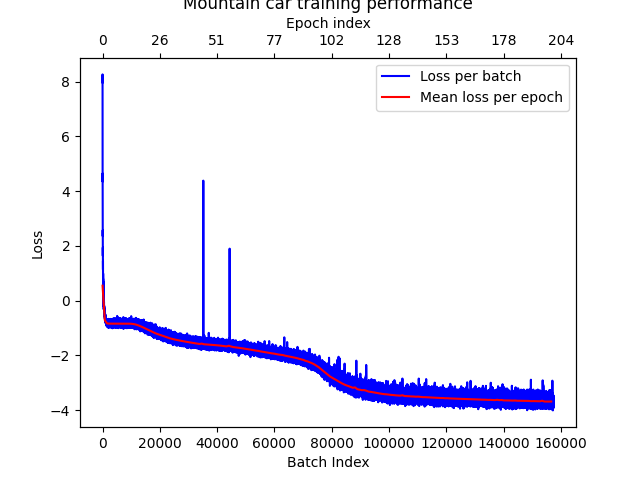

In [59]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot()
lossPerBatch = [l for x in losses for l in x]
ax.plot(lossPerBatch, label="Loss per batch", color='blue')
ax.plot(range(0, len(lossPerBatch), math.ceil(len(lossPerBatch) / 200.0)), [sum(x) / len(x) for x in losses], label="Mean loss per epoch", color='red')
ax.set_xlabel("Batch Index")
ax.set_ylabel("Loss")
ax.set_title("Mountain car training performance")


xticks = [0, 20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000]
ax2 = ax.twiny()
ax2.set_xlabel("Epoch index")
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(xticks)
ax2.set_xticklabels([math.ceil(x * 200 / len(lossPerBatch)) for x in xticks])
ax.legend()
plt.show()

### TEST THE MODEL ###

Handled all samples: 4394 out of 4394


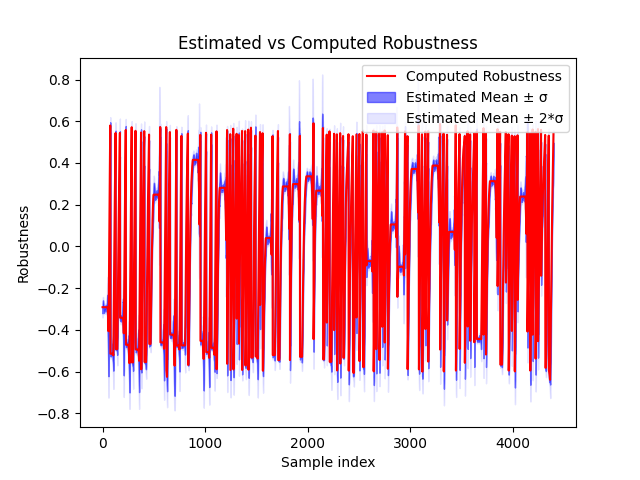

In [6]:
%matplotlib widget 
testResults = estimator.test(testData) #[:2100])
#testResults = testResults + estimator.test(testData[2100:])

### Show amount of misses in test ###

In [8]:
offsets = {}
signWrongs = 0
wrongValues = []
for i in testResults:
	# i = (outputTensor, expectedValue)
	expectedMean = i[0][0].item()
	stddev = math.sqrt(i[0][1].item())
	expected = i[1]

	amountOfVariances = math.ceil(
		abs(expected - expectedMean) / stddev
	)
	if amountOfVariances not in offsets:
		offsets[amountOfVariances] = 1
	else:
		offsets[amountOfVariances] += 1
	if math.copysign(1, i[0][0].item()) != math.copysign(1, i[1]):
		signWrongs += 1
		wrongValues.append(i[0][0].item())
print(signWrongs)
print(offsets)
print(wrongValues)
print(sum(wrongValues)/len(wrongValues))


50
{1: 3750, 2: 612, 3: 27, 4: 3, 13: 1, 5: 1}
[-0.03696853667497635, -0.0024278610944747925, -0.0365237332880497, -0.01596653461456299, -0.00036265701055526733, -0.08222417533397675, -0.022716403007507324, -0.003168918192386627, -0.01909046620130539, -0.001075252890586853, -0.013216190040111542, -0.009489268064498901, -0.00273190438747406, -0.009911924600601196, -0.009171679615974426, 0.08150717616081238, 0.08058156073093414, 0.09883907437324524, -0.007940255105495453, -0.006516106426715851, 0.0025660693645477295, -0.009671062231063843, -0.01054467260837555, -0.034768808633089066, -0.02395489439368248, 0.009773015975952148, -0.013298608362674713, -0.005602255463600159, -0.012986183166503906, 0.0016208291053771973, 0.043359577655792236, -0.022886116057634354, -0.01994897425174713, -0.007999628782272339, -0.011003822088241577, -0.014542721211910248, -0.026337027549743652, -0.002768188714981079, 0.18742719292640686, -0.009745076298713684, -0.02154351770877838, 0.005737677216529846, -0.02

### PRINT PARAMETERS ###

In [209]:
model_parameters = filter(lambda p: p.requires_grad, estimator.model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
with open('params.txt', 'w') as f:
	f.write(list(filter(lambda p: p.requires_grad, estimator.model.parameters())).__str__())

18130


### Runtime Measurement ###

Handled 5000 out of 205731 samples
Handled 10000 out of 205731 samples
Handled 15000 out of 205731 samples
Handled 20000 out of 205731 samples
Handled 25000 out of 205731 samples
Handled 30000 out of 205731 samples
Handled 35000 out of 205731 samples
Handled 40000 out of 205731 samples
Handled 45000 out of 205731 samples
Handled 50000 out of 205731 samples
Handled 55000 out of 205731 samples
Handled 60000 out of 205731 samples
Handled 65000 out of 205731 samples
Handled 70000 out of 205731 samples
Handled 75000 out of 205731 samples
Handled 80000 out of 205731 samples
Handled 85000 out of 205731 samples
Handled 90000 out of 205731 samples
Handled 95000 out of 205731 samples
Handled 100000 out of 205731 samples
Handled 105000 out of 205731 samples
Handled 110000 out of 205731 samples
Handled 115000 out of 205731 samples
Handled 120000 out of 205731 samples
Handled 125000 out of 205731 samples
Handled 130000 out of 205731 samples
Handled 135000 out of 205731 samples
Handled 140000 out of

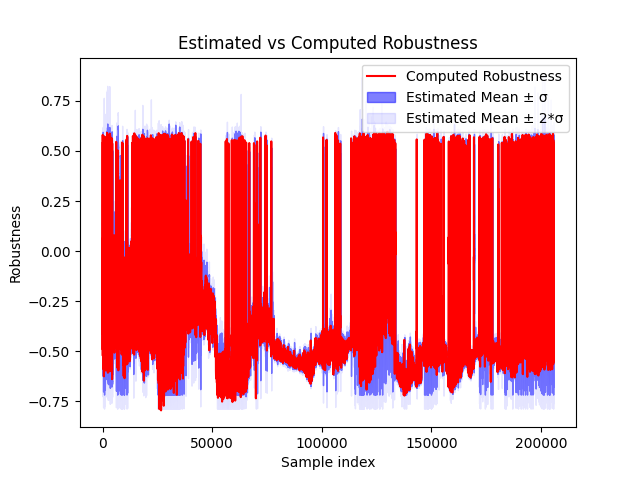

Estimator took 148.83627462387085


In [11]:
fullData = testData + trainData

start = time.time()
x = estimator.test(fullData)
end = time.time()

print(f"Estimator took {end - start}")